In [39]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.linear_model import LinearRegression
import pingouin as pg

from math import sin, cos, atan2, sqrt, pi
from eda_helpers import normality_check, count_outliers
from stat_inference_helpers import custom_corr, evaluate_model

**1. Start from the Summary coming from the Exploratory Data Analysis (EDA)**

**Summary:**
 - Target: `Price` numerical continuous variable;
 - There are 6 features: 4 continuous, 2 text;
 - There are 3 missing values in target variable;
 - There are no missing values in features;
 - `Price`, `Area` and `Room` have right-skewed distribution and 56, 33, 62 outliers respectively. However if we look closer to these outliers, we'll see that all of them are just big (and thus expencive) houses. These values will not be considered as outliers;
 - There are 2 outiers in `Longitude`, that are much lower than the mean;
 - Outliers of `Latitude` create a cluster togeter with other points and will not be considered as outliers.
 - There is one point, which is an outlier niether for longitude, not for latitude, but when plotting coordinates, we see that it is far from the main distribution of points. It will be considered an outlier;
 - Most values of both text features (`Address` and `Zip`) are unique, thus not informative for prediction;
 - When removing letters from `Zip` code, there are 70 unique values, which represent areas of the city. The assumption is they are more generalized, than original format of zip code.
 

**2. Begin to process the dataset accordingly, e.g., by dealing with missing values, feature engineering and transformation;**

In [40]:
data = pd.read_csv("data/data_train.csv")

data_info = pd.read_parquet("./data/data_info.parquet")
print(f'o Shape of train dataset: {data.shape}')
display(data.sample(3))
print('o Data information')
display(data_info.transpose())
print(f'o Number of duplicate rows that will be removed: {data.duplicated().sum()}')
print(f'o Data type in Dataset: {data_info["data_type"].unique()}')
print(f"o Columns: {data_info.index.tolist()}")

o Shape of train dataset: (739, 7)


,Address,Zip,Price,Area,Room,Lon,Lat
624,"Robert Fruinlaan 24 III, Amsterdam",1065 XX,350000.0,68,3,4.829034,52.363730
412,"Elpermeer 250, Amsterdam",1025 AP,300000.0,85,4,4.947646,52.402266
322,"Bilderdijkstraat 201 2, Amsterdam",1053 KS,250000.0,29,2,4.872989,52.366428


o Data information


index,Price,Address,Zip,Area,Room,Lon,Lat
data_type,continuous,text,text,continuous,descrete,continuous,continuous
missing values,3,0,0,0,0,0,0
distribution,right_skewed,not applicable,not applicable,right_skewed,right_skewed,normal,heavy_tailed
n outliers,0,0,0,1,0,2,0


o Number of duplicate rows that will be removed: 1
o Data type in Dataset: ['continuous' 'text' 'descrete']
o Columns: ['Price', 'Address', 'Zip', 'Area', 'Room', 'Lon', 'Lat']


In [41]:
#remove duplicates:
data = data.drop_duplicates()

# remove Longitude outliers (Lon < 4.7)
data.drop(data[data['Lon']< 4.7].index, inplace=True)

# reset indexes after removing rows
data = data.reset_index()
data = data.drop(columns=['index'])
data.tail()


,Address,Zip,Price,Area,Room,Lon,Lat
732,"Cliostraat 23 HS, Amsterdam",1077 KB,1025000.0,135,4,4.875881,52.347368
733,"Prinsenstraat 4, Amsterdam",1015 DC,915000.0,88,5,4.887412,52.377742
734,"Revaleiland 383, Amsterdam",1014 ZG,690000.0,100,3,4.881116,52.393955
735,"Linnaeusstraat 243 1., Amsterdam",1093 ER,450000.0,60,4,4.928173,52.355788
736,"Van Gentstraat 6 1, Amsterdam",1055 PE,425000.0,69,4,4.851176,52.383021


**3. For supervised learning, study the relationship between features, a.k.a. independent variables (IV), with the target, a.k.a. the dependent variable (DV).**


- **a.** Study the [correlation](https://www.statisticshowto.com/probability-and-statistics/correlation-analysis/) for both **Discrete** and **Numerical** features.
- **b.** Apply [ANOVA](https://www.statisticshowto.com/probability-and-statistics/hypothesis-testing/anova/#OneWayANOVA) between **Nominal** feature and **Numerical** target;
- **c.** If necessary, transform or construct new features and re-apply the same statistical test;

**!!!** whenever possible, plot the variables to assess whether the results coming from the statistical test are driven by outliers or imbalanced facets;

* Before applying tests it makes sence to fill the missing values:

In [42]:
missing_data = data[data.isna().any(axis=1)]
missing_data

,Address,Zip,Price,Area,Room,Lon,Lat
110,"Zeeburgerkade 760, Amsterdam",1019 HT,NaN,107,3,4.945022,52.369244
417,"Suikerplein 16, Amsterdam",1013 CK,NaN,81,3,4.880976,52.389623
527,"Haarlemmerweg 705, Amsterdam",1067 HP,NaN,366,12,4.787874,52.383877


In [43]:
ind = data.loc[(data['Price'].isna()) & (data['Zip'].str.contains('1019'))]
ind


,Address,Zip,Price,Area,Room,Lon,Lat
110,"Zeeburgerkade 760, Amsterdam",1019 HT,NaN,107,3,4.945022,52.369244


To determine missing prices it is possible to count average price per square meter (sqm) in the neighbourhood and then multiply it by the house's area:

In [44]:
zips = []

for i in range(missing_data.shape[0]):
    zips.append(list(missing_data['Zip'])[i][:4])

data['Price per sqm'] = data['Price'] / data['Area']

for i in zips:

    #create dataframe with all houses in the neighbourhood
    data_copy = data.loc[data['Zip'].str.contains(i)]
    # display(data_copy)

    # get avg price per sqm in the neighbourhood
    mean = data_copy.loc[(data_copy['Zip'].str.contains(i)), 'Price per sqm'].mean()

    #set this value to the row with missing price
    data.loc[(data['Price'].isna()) & (data['Zip'].str.contains(i)), 'Price per sqm'] = mean
    print(f'o Avg Price per sqm in the neighbourhood: {mean}')
    target_row = data.loc[(data['Price'].isna()) & (data['Zip'].str.contains(i))]
    print(f'o Row with imputed value: {target_row.index[0]}')

    # get area value of the row with missing price
    area = target_row['Area']

    # set missing price by multiplying average price by size of the house in sqm
    data.loc[(data['Price'].isna()) & (data['Zip'].str.contains(i)), 'Price'] = mean * area
    display(data.loc[data['Zip'].str.contains(i)])


o Avg Price per sqm in the neighbourhood: 6211.207018260803
o Row with imputed value: 110


,Address,Zip,Price,Area,Room,Lon,Lat,Price per sqm
74,"Borneokade 70, Amsterdam",1019 AW,1.750000e+06,246,8,4.909819,52.368653,7113.821138
110,"Zeeburgerkade 760, Amsterdam",1019 HT,6.645992e+05,107,3,4.945022,52.369244,6211.207018
119,"Borneolaan 342, Amsterdam",1019 KL,4.500000e+05,85,3,4.937516,52.370995,5294.117647
148,"Javakade 144, Amsterdam",1019 RW,7.500000e+05,118,4,4.930455,52.377871,6355.932203
199,"Levantplein 9, Amsterdam",1019 MA,1.450000e+06,273,5,4.942112,52.376819,5311.355311
253,"Nieuwevaartweg, Amsterdam",1019 AL,6.500000e+05,87,4,4.954376,52.367982,7471.264368
262,"Panamalaan 84, Amsterdam",1019 AZ,6.950000e+05,107,4,4.934082,52.371077,6495.327103
288,"Levantkade 170, Amsterdam",1019 BG,5.490000e+05,91,5,4.943456,52.376191,6032.967033
360,"KNSM-laan 609, Amsterdam",1019 LD,5.390000e+05,88,3,4.942972,52.377442,6125.000000
375,"KNSM-laan 479 PP, Amsterdam",1019 LG,5.850000e+05,87,3,4.941549,52.377347,6724.137931


o Avg Price per sqm in the neighbourhood: 7384.105771224381
o Row with imputed value: 417


,Address,Zip,Price,Area,Room,Lon,Lat,Price per sqm
43,"Droogbak 5 B, Amsterdam",1013 GE,5.950000e+05,78,3,4.893924,52.379828,7628.205128
77,"Oostzaanstraat 255, Amsterdam",1013 WJ,7.250000e+05,118,4,4.872520,52.392217,6144.067797
89,"Spaarndammerstraat 62 1, Amsterdam",1013 SZ,3.450000e+05,48,2,4.880745,52.388005,7187.500000
167,"Van Noordtkade 140, Amsterdam",1013 CA,3.350000e+05,61,2,4.881952,52.389025,5491.803279
184,"Westerdoksdijk 375, Amsterdam",1013 AD,5.250000e+05,63,3,4.892914,52.384794,8333.333333
274,"Haparandaweg 932 A, Amsterdam",1013 BD,5.000000e+05,76,3,4.878134,52.395229,6578.947368
340,"Haarlemmerdijk 178 C, Amsterdam",1013 JK,3.750000e+05,44,2,4.884769,52.384121,8522.727273
352,"Droogbak 6 B, Amsterdam",1013 GE,5.750000e+05,80,3,4.893865,52.379863,7187.500000
361,"Adrichemstraat 15, Amsterdam",1013 DR,4.500000e+05,73,3,4.877698,52.388468,6164.383562
417,"Suikerplein 16, Amsterdam",1013 CK,5.981126e+05,81,3,4.880976,52.389623,7384.105771


o Avg Price per sqm in the neighbourhood: 4341.84676704018
o Row with imputed value: 527


,Address,Zip,Price,Area,Room,Lon,Lat,Price per sqm
3,"De Bazelhof 24, Amsterdam",1067 LZ,4.000000e+05,107,6,4.795810,52.376916,3738.317757
21,"Pieter van der Werfstraat 127, Amsterdam",1067 EM,3.500000e+05,87,3,4.802688,52.382381,4022.988506
53,"Teldershof 57, Amsterdam",1067 ML,3.500000e+05,88,3,4.800286,52.380052,3977.272727
138,"Hendrik Bulthuisstraat 8, Amsterdam",1067 SC,3.450000e+05,69,4,4.795948,52.374337,5000.000000
139,"J.G. Suurhoffstraat 123, Amsterdam",1067 VR,4.250000e+05,102,4,4.789341,52.380775,4166.666667
154,"Sam van Houtenstraat 191 C, Amsterdam",1067 JG,3.750000e+05,94,4,4.800745,52.379133,3989.361702
192,"Aalbersestraat 232, Amsterdam",1067 GM,2.950000e+05,65,4,4.798255,52.378644,4538.461538
330,"Jan van Duivenvoordestraat 85 2, Amsterdam",1067 MT,3.500000e+05,92,3,4.802582,52.379007,3804.347826
338,"Kruisherenpad 7, Amsterdam",1067 DZ,4.400000e+05,115,6,4.802015,52.380829,3826.086957
351,"Gerda Brautigamstraat 37, Amsterdam",1067 VM,5.450000e+05,110,4,4.789083,52.379219,4954.545455


Add info about 'Price per sqm'

In [45]:
data_info.loc['Price per sqm', 'data_type'] = 'continuous'
data_info.loc['Price per sqm', 'missing values'] = 0
normality_check(data, data_info, ['Price per sqm'])
data_info

,data_type,missing values,distribution,n outliers
index,,,,
Price,continuous,3.0,right_skewed,0.0
Address,text,0.0,not applicable,0.0
Zip,text,0.0,not applicable,0.0
Area,continuous,0.0,right_skewed,1.0
Room,descrete,0.0,right_skewed,0.0
Lon,continuous,0.0,normal,2.0
Lat,continuous,0.0,heavy_tailed,0.0
Price per sqm,continuous,0.0,not normal,NaN


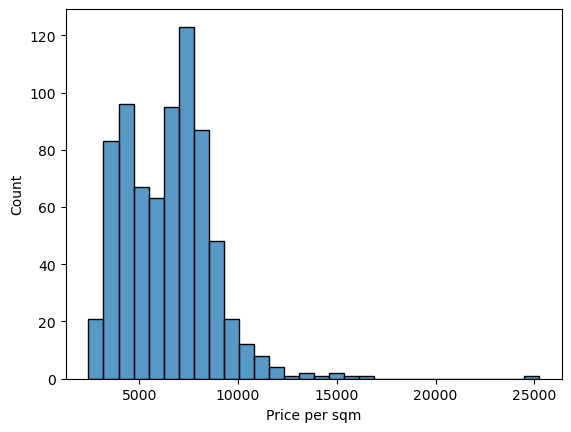

In [46]:
# plot 'Price per sqm' distribution as a histplot
plot = sns.histplot(x = data['Price per sqm'], bins = 30)

**Distribution is right-skewed**

In [47]:
data_info.loc['Price per sqm', 'distribution'] = 'right_skewed'

Check outliers of Price per sqm

In [48]:
count_outliers(data = data, data_info = data_info, features = ['Price per sqm'])

o 9 datapoints with Price per sqm > 12649.031296572282


,Address,Zip,Price,Area,Room,Lon,Lat,Price per sqm
22,"Pieter Cornelisz. Hooftstraat 169 B, Amsterdam",1071 BW,1695000.0,117,3,4.876144,52.358928,14487.179487
149,"Zocherstraat 23 X, Amsterdam",1054 LR,1200000.0,81,3,4.858004,52.357400,14814.814815
162,"Prins Hendrikkade 512, Amsterdam",1011 TE,389000.0,30,2,4.906059,52.374085,12966.666667
277,"Keizersgracht 544, Amsterdam",1017 EL,5950000.0,394,10,4.887378,52.365078,15101.522843
418,"Dam 5 V, Amsterdam",1012 JS,4495000.0,178,5,4.894290,52.373106,25252.808989
554,"Leonard Bernsteinstraat 96 A, Amsterdam",1082 MR,1750000.0,130,3,4.872151,52.336348,13461.538462
587,"Amstel 102, Amsterdam",1017 AD,2325000.0,150,6,4.896842,52.366965,15500.000000
589,"Huidekoperstraat 24 F, Amsterdam",1017 ZM,2475000.0,183,4,4.897473,52.358943,13524.590164
644,"Nieuwe Keizersgracht 570 L, Amsterdam",1018 VG,1050000.0,63,3,4.908850,52.365524,16666.666667


The biggest outlier is a house, located on a Dam square, which is the most famous square of Amsterdam, so it is normal, that it is so expencive. Besides that, according to google maps, this house is a new-build or recently renovated. All other houses in outliers list are mostly located in the city center or next to tourist attractions (like row with address Zocherstraat 23 - next to Vondelpark).

In [49]:
data_info.loc['Price per sqm', 'n outliers'] = 0
data_info

,data_type,missing values,distribution,n outliers
index,,,,
Price,continuous,3.0,right_skewed,0.0
Address,text,0.0,not applicable,0.0
Zip,text,0.0,not applicable,0.0
Area,continuous,0.0,right_skewed,1.0
Room,descrete,0.0,right_skewed,0.0
Lon,continuous,0.0,normal,2.0
Lat,continuous,0.0,heavy_tailed,0.0
Price per sqm,continuous,0.0,right_skewed,0.0


**a. Study correlations between numerical features:**

As in this dataset most of variables are not distributed normally, we have to use a custom function, that will dicide if Pearson's or Spearman's correlation test has to be applied:

In [50]:
correlations_df = custom_corr(data, data_info, data.columns)
correlations_df

,method,feature1,feature2,r-value,p-value,stat-sign,N
0,Spearman,Lon,Price,-0.025781,4.846616e-01,False,737
1,Spearman,Lon,Area,0.078756,3.253710e-02,True,737
2,Spearman,Lon,Room,0.014287,6.986006e-01,False,737
3,Spearman,Lon,Lat,-0.091303,1.315111e-02,True,737
4,Spearman,Lon,Price per sqm,-0.111327,2.473536e-03,True,737
5,Spearman,Price,Area,0.720851,3.896903e-119,True,737
6,Spearman,Price,Room,0.518670,5.467193e-52,True,737
7,Spearman,Price,Lat,0.062011,9.252604e-02,False,737
8,Spearman,Price,Price per sqm,0.437909,7.000172e-36,True,737
9,Spearman,Area,Room,0.773116,1.774729e-147,True,737


As we can see here, most of statistically signifficant correlations are between a feature and a target (in this case there are 2 targets: price and price per sqm). Longitude and Latitude have no impact on price, however both have impact on price per sqm. Also there is positive correlation between Area and Rooms which seems to be fair. This features might be transformed later.

Let's plot Area and Room feature vs. Price to see the character of dependancy:

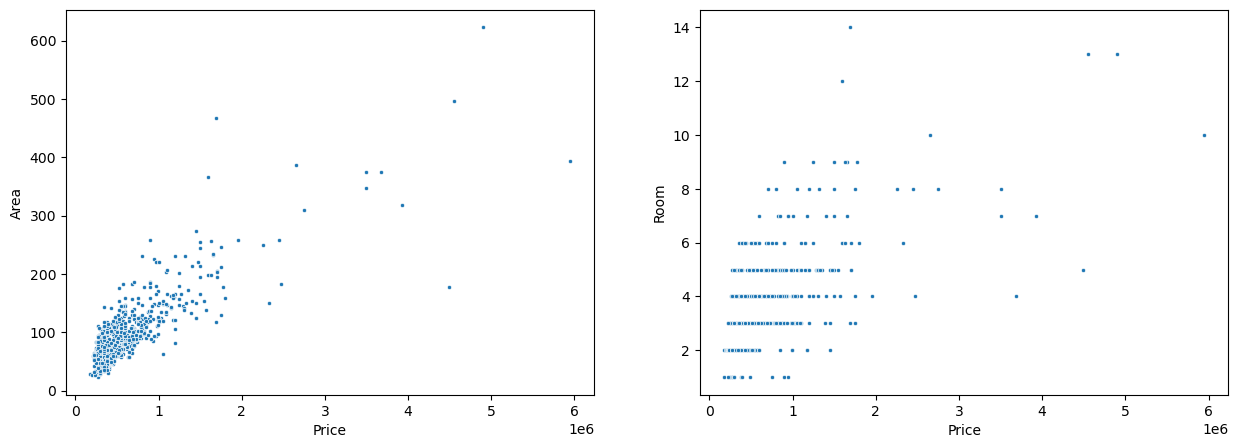

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for count, feature in enumerate(['Area', 'Room']):
    sns.scatterplot(data = data, x = 'Price', y = feature, marker='.', ax = axes.flatten()[count])

**This 2 feaures don't give us much information: none of them can be described with any known distribution.**

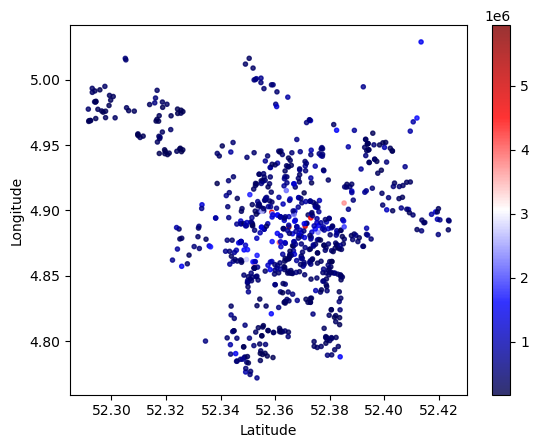

In [52]:
# plot longitude vs latitude and hue by price
plt.scatter(data['Lat'], data['Lon'], alpha = .8, c = data['Price'], cmap = 'seismic', marker='.')

plt.xlabel('Latitude')
plt.ylabel('Longitude')
cbar = plt.colorbar()

This plot is more informative: the darkest points are mostly located on the outskirts and **central** ones are more **expencive**.

**b. Study dependency of target on the nominal features:**

As it was found out in EDA, the Address is unoque for every datapoint, so it cannot be used as a predictor. However the Zip code has a pattern: The first two digits indicate a `City` and a `Region`, the third digit represents the `Location` and the fourth digit represents the `District`. The first letter indicates the `delivery area`, and the second letter indicates the subdivision of the delivery area. Consequently, the postcode and house number uniquely define a postal address. Let's us create several features based on subsection of the Zip code ([source](https://en.youbianku.com/Netherlands))

**Option 1**: Divide Zip to city, region, location, district, delivery area

In [56]:
# 1. create a copy of data to experiment with Zip
data1 = data.copy().drop(columns=['Address'])
data1.sample()

,Zip,Price,Area,Room,Lon,Lat,Price per sqm
263,1069 LD,295000.0,91,4,4.795401,52.348468,3241.758242


In [57]:
# 2. transform Zip
data1['Zip city'] = np.nan
data1['Zip region'] = np.nan
data1['Zip location'] = np.nan
data1['Zip district'] = np.nan
data1['Delivery area'] = ''
for row in range(data1.shape[0]):
    data1.loc[row, 'Zip city'] = str(data1.loc[row, 'Zip'][0])
    data1.loc[row, 'Zip region'] = str(data1.loc[row, 'Zip'][1])
    data1.loc[row, 'Zip location'] = str(data1.loc[row, 'Zip'][2])
    data1.loc[row, 'Zip district'] = str(data1.loc[row, 'Zip'][3])
    data1.loc[row, 'Delivery area'] = str(data1.loc[row, 'Zip'][-2:])
data1 = data1.drop(columns=['Zip'])
data1.sample

display(data1['Zip city'].value_counts())
display(data1['Zip region'].value_counts())
display(data1['Zip location'].value_counts())
display(data1['Zip district'].value_counts())
display(data1['Delivery area'].value_counts())

Zip city
1    737
Name: count, dtype: int64

Zip region
0    668
1     69
Name: count, dtype: int64

Zip location
1    148
5    136
6    120
7     85
0     69
9     61
2     44
3     41
8     33
Name: count, dtype: int64

Zip district
7    114
5     94
3     87
2     86
4     81
1     73
8     73
6     66
9     48
0     15
Name: count, dtype: int64

Delivery area
EE    9
VG    7
XR    6
BG    6
AD    6
     ..
RR    1
GR    1
DL    1
AC    1
ZG    1
Name: count, Length: 322, dtype: int64

Zip city is always 1, so has no predictive power. Let's remove it:

In [58]:
data1 = data1.drop(columns=['Zip city'])

Let's now check if the rest of new features have impact on target. For this purpose custom function will be applied, which first checks if the variances of the variable groups are equal, and then performs either normal ANOVA or Welch ANOVA. It is also better to normalize the target by transforming it with logarithm function:

In [59]:
data1['log_Price'] = np.log(data1['Price'])

In [61]:
def custom_anova(data: pd.DataFrame, grouping_var: list, feature: str, result_table: pd.DataFrame, plot: bool = True) -> pd.DataFrame:

    for col in grouping_var:

        # check is variances are homogeneous
        values_per_group = {
            grp_label: values
            for grp_label, values in data.groupby(col, observed=True)['Price']
        }
        
        # create a list with lists of values
        (levene, levene_p_value) = stats.levene(*values_per_group.values())
        if levene_p_value >0.05:
            variance = 'Homogeneous'
        else:
            variance = 'Heterogeneous'

        # normal ANOVA can be applied only when the variances are homogeneous
        if variance == 'Homogeneous':
            test_type = 'One way ANOVA'
            (f_value, p_value) = stats.f_oneway(*values_per_group.values())

        else:
            test_type = 'Welch ANOVA'
            welch_df = pg.welch_anova(dv = feature, between = col, data = data)
            p_value = welch_df['p-unc']
            f_value = welch_df['F']

        dict_result = {
            "test-type": test_type,
            "feature": col,
            "group-var": 'Price',
            "f-value": round(f_value, 3),
            "p-value": round(p_value, 3),
            "stat-sign": (p_value < 0.05),
            "variance": variance
        }
        df_result = pd.DataFrame(data=dict_result, index=[0])
        result_table = pd.concat([result_table, df_result], ignore_index=True) 

        # plot grouping var vs feature as boxplots
        if plot:
            boxplot, ax = plt.subplots(figsize = (15,4))
            _ = sns.boxplot(ax=ax, x=data[col], y=data[feature])
            _ = sns.swarmplot(
                ax=ax, x=data[col], y= data[feature], color=".25", alpha=0.50, size=2
            )
            _ = ax.set_title(f"Boxplot {feature} across {col}")
            plt.xticks(rotation=90)

    return result_table

/Users/nadiiaduiunova/miniconda3/envs/to_remove/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/nadiiaduiunova/miniconda3/envs/to_remove/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/nadiiaduiunova/miniconda3/envs/to_remove/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/nadiiaduiunova/miniconda3/envs/to_remove/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  

,test-type,feature,group-var,f-value,p-value,stat-sign,variance
0,Welch ANOVA,Zip region,Price,277.171,0.000,True,Heterogeneous
1,Welch ANOVA,Zip location,Price,46.355,0.000,True,Heterogeneous
2,One way ANOVA,Zip district,Price,1.460,0.159,False,Homogeneous
3,One way ANOVA,Delivery area,Price,0.711,0.999,False,Homogeneous


/Users/nadiiaduiunova/miniconda3/envs/to_remove/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/nadiiaduiunova/miniconda3/envs/to_remove/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/nadiiaduiunova/miniconda3/envs/to_remove/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/nadiiaduiunova/miniconda3/envs/to_remove/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  

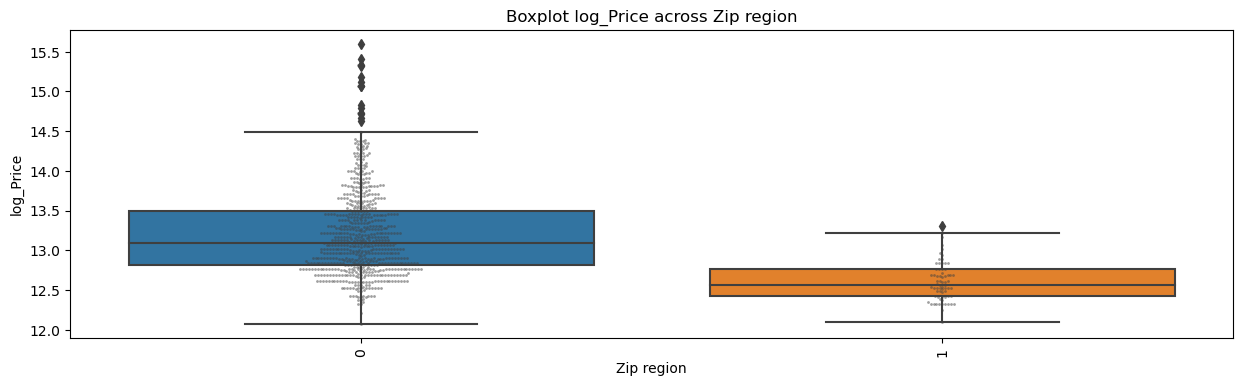

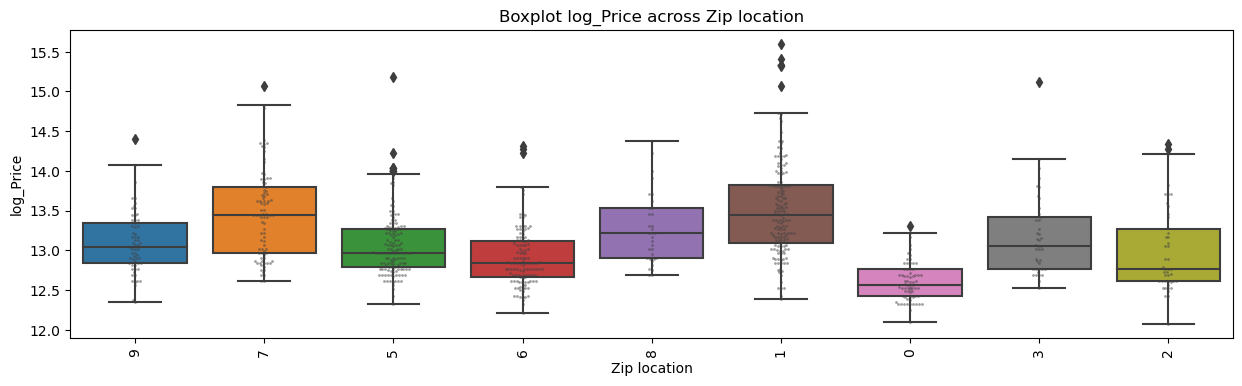

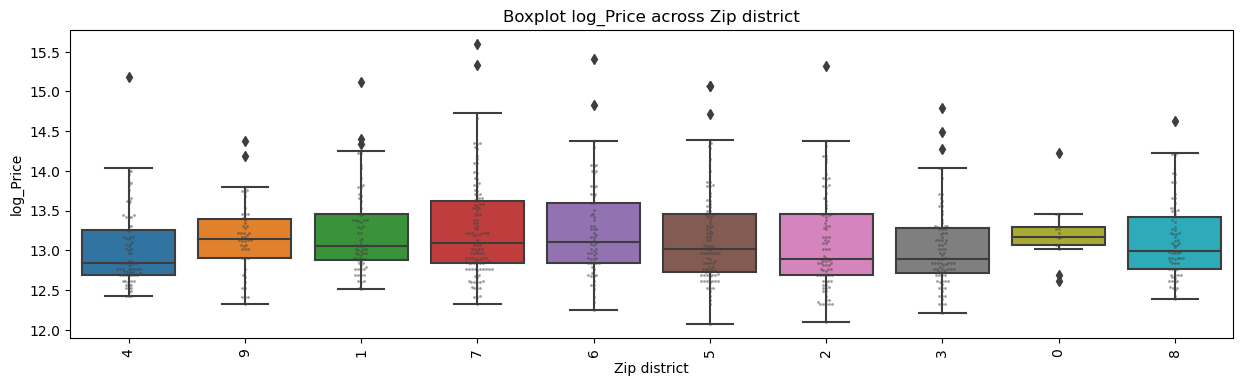

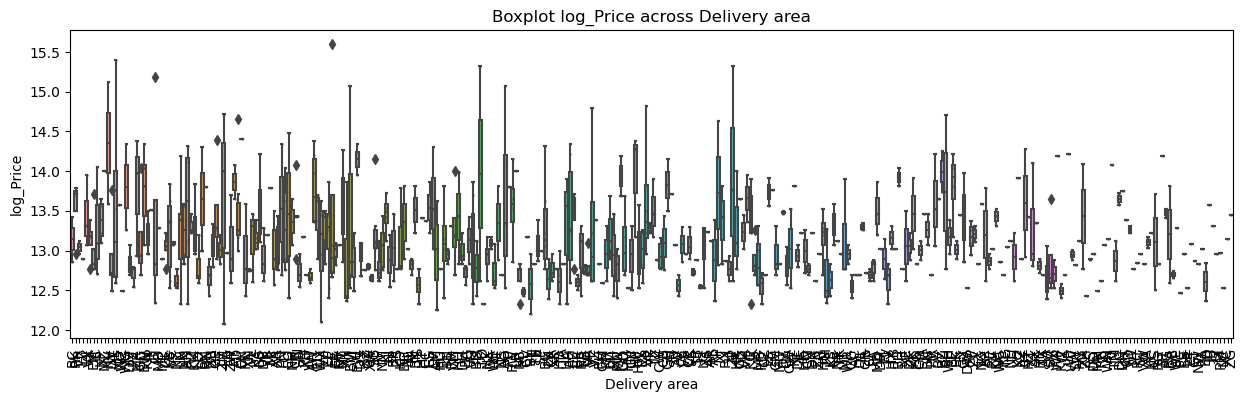

In [64]:
anova_df = pd.DataFrame()
custom_anova(data1, ['Zip region', 'Zip location', 'Zip district', 'Delivery area'], 'log_Price', anova_df)

**Option 2**: Divide Zip to city(first 2 digits), and location (3rd and 4th digits). Drop letters.

In [16]:
# 2. transform Zip
data1['Zip city'] = np.nan
data1['Zip area'] = np.nan
for row in range(data1.shape[0]):
    data1.loc[row, 'Zip city'] = str(data1.loc[row, 'Zip'][0:2])
    data1.loc[row, 'Zip area'] = str(data1.loc[row, 'Zip'][2:4])
data1 = data1.drop(columns=['Zip'])

display(data1['Zip city'].value_counts())
display(data1['Zip area'].value_counts())

NameError: name 'data1' is not defined

In [ ]:
# set data info for the rest of zip features

data_info.loc['Zip city', 'data_type'] = 'categorical'
data_info.loc['Zip area', 'data_type'] = 'categorical'
data_info.loc['Zip city', 'missing values'] = 0
data_info.loc['Zip area', 'missing values'] = 0

In [ ]:
def custom_anova(data: pd.DataFrame, grouping_var: list, feature: str, result_table: pd.DataFrame, plot: bool = True) -> pd.DataFrame:

    for col in grouping_var:

        # check is variances are homogeneous
        values_per_group = {
            grp_label: values
            for grp_label, values in data.groupby(col, observed=True)['Price']
        }
        
        # create a list with lists of values
        (levene, levene_p_value) = stats.levene(*values_per_group.values())
        if levene_p_value >0.05:
            variance = 'Homogeneous'
        else:
            variance = 'Heterogeneous'

        # normal ANOVA can be applied only when the variances are homogeneous
        if variance == 'Homogeneous':
            test_type = 'One way ANOVA'
            (f_value, p_value) = stats.f_oneway(*values_per_group.values())

        else:
            test_type = 'Welch ANOVA'
            welch_df = pg.welch_anova(dv = feature, between = col, data = data)
            p_value = welch_df['p-unc']
            f_value = welch_df['F']

        dict_result = {
            "test-type": test_type,
            "feature": col,
            "group-var": 'Price',
            "f-value": round(f_value, 3),
            "p-value": round(p_value, 3),
            "stat-sign": (p_value < 0.05),
            "variance": variance
        }
        df_result = pd.DataFrame(data=dict_result, index=[0])
        result_table = pd.concat([result_table, df_result], ignore_index=True) 

        # plot grouping var vs feature as boxplots
        if plot:
            boxplot, ax = plt.subplots(figsize = (15,4))
            _ = sns.boxplot(ax=ax, x=data[col], y=data[feature])
            _ = sns.swarmplot(
                ax=ax, x=data[col], y= data[feature], color=".25", alpha=0.50, size=2
            )
            _ = ax.set_title(f"Boxplot {feature} across {col}")
            plt.xticks(rotation=90)

    return result_table

anova_df = pd.DataFrame()
custom_anova(data1, ['Zip city', 'Zip area'], 'log(Price)', anova_df)

In [ ]:
sns.boxplot(x = data1['Zip area'], y = data1['Price'])

Longitude, Latitude, Zip location and Zip district have no impact on target. Also, Area and room are hightly correlated, so Room will also be removed, because the its impact on target is weaker.

In [ ]:
data['Zip region'] = data1['Zip region']
data1 = data1.drop(columns=['Room', 'Lon', 'Lat', 'Zip location', 'Zip district'])
data1

**4. Create a benchmark model**

Let's create an initial model and measure the benchmark accuracy. The model will not contain custom features (Price per sqm and Distance from center) and will only require text data transformation and scaling of numerical features:
 1. Address wil be removed as it is unique for every datapoint, so has no predictive power
 2. Zip code will be cut to just numbers and checked if it is correlated with target (every digit in the Zip code has its own meaning, so instead of 1 feature there would be 4)
 3. Price, Area and Room features will be normalized.

In [ ]:
# 1. remove extra or unimportant columns
# 2. transform Zip
# 3. Normalize Price and Area:

data1['log(Price)'] = np.log(data1['Price'])
data1['log(Area)'] = np.log(data1['Area'])
data_info.loc['log(Price)', 'data_type'] = 'continuous'
data_info.loc['log(Area)', 'data_type'] = 'continuous'
data_info.loc['log(Price)', 'missing values'] = 0
data_info.loc['log(Area)', 'missing values'] = 0

normality_check(data1, data_info, ['log(Price)', 'log(Area)'])


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for i, col in enumerate(['log(Price)', 'log(Area)']):
    plot = sns.histplot(ax=axes.flatten()[i], x = data1[col], bins = 30)

Logging Price did not make it normaly distributed, but it looks much better than initial Price distribution.

In [ ]:
data_info.loc['log(Price)', 'distribution'] = 'right_skewed'
data_info

In [ ]:
correlations_df = custom_corr(data1, data_info, features=['log(Price)', 'log(Area)', 'Zip region'])
correlations_df

According to correlation matrix, the data is ready to be fed to the initial model to get benchmark accuracy:

In [ ]:
X1 = data1.drop(columns=['Price', 'Area', 'log(Price)'])
y1 = data1['log(Price)']

model1 = LinearRegression()
model1.fit(X1, y1)
y_pred1 = model1.predict(X1)

In [ ]:
# back transformation from log of price to price
y_pred1 = np.exp(y_pred1)

In [ ]:
results = pd.DataFrame()
results['Model'] = ''
results['List of used features'] = []
results['Target'] = ''
results['RMSE'] = np.nan
results['MAE'] = np.nan
results['r_value'] = np.nan
results['corr_coef'] = np.nan

In [ ]:
rmse1, mae1, r_value1, corr1 = evaluate_model('Linear Regression', list(X1.columns), 'log(Price)', data1['Price'], y_pred1, results)
results

This model is no good: r-value is very low as well as correlation coefficient. In the next file futher feature engineeting and model selection/regularization will be performed to get better results

In [ ]:
# save all the dataframes for futher use

results.to_parquet("./data/results.parquet", index=False)
data_info.to_parquet("./data/data_info.parquet")
data.to_csv("./data/data_train.csv", index=False)


## Summary:


1. Area and Room features are correlated
2. Lon, Lat, Address have no impact on target
3. It is prommising to create a 'Distance' feature out of Lon and Lat
4. The whole Zip code has no influence on target as well. However, the second digit, that means Region and has values [0,1]
5. Price per square meter could be an alternative target. This assumption requires a proof.